In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import time 

In [3]:
q_t1 = np.load("target_1.npy") # \in \mathcal{R}^{2}
print(q_t1.shape)
q_t2 = np.load("target_2.npy") #\in \mathcal{R}^{2}
print(q_t2.shape)

(2, 60)
(2, 60)


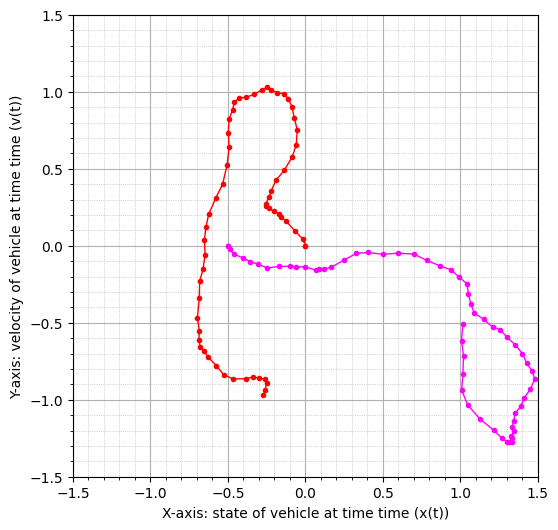

In [4]:
plt.figure(figsize=(6, 6))
plt.xlim([-1.5, 1.5])
plt.ylim([-1.5, 1.5])
plt.plot(q_t1[0,:], q_t1[1,:], linewidth=1, color='red', linestyle='-')
plt.plot(q_t1[0,:], q_t1[1,:], 'o', color='red', markersize=3)
plt.plot(q_t2[0,:], q_t2[1,:], linewidth=1, color='magenta', linestyle='-')
plt.plot(q_t2[0,:], q_t2[1,:], 'o', color='magenta', markersize=3)
plt.grid(True)
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth=0.8)      
plt.grid(which='minor', linestyle=':', linewidth=0.5)   
plt.xlabel('X-axis: state of vehicle at time time (x(t))')
plt.ylabel('Y-axis: velocity of vehicle at time time (v(t))') 
plt.show()

In [5]:
T = 60        # number of time steps
n = 4         # state dimension (p in R^2, v in R^2)

# State trajectory variable: shape (n, T)
x = cp.Variable((n, T))
x_i = np.zeros((12, n, T))  # reference trajectory variable: shape (n, T)
u_i = np.zeros((12, 2, T-1))  # reference control input variable: shape (n), T-1)

u = cp.Variable((2, T-1))  # control input variable: shape (2, T-1)

rho = 0.1

prior = [[0, 1], [0.1, 0.9], [0.2, 0.8], [0.3, 0.7], [0.4, 0.6], [0.5, 0.5], [0.6, 0.4], [0.7, 0.3], [0.8, 0.2], [0.9, 0.1], [1, 0]]     # prior probabilities

E = np.array([[1, 0, 0, 0],
              [0, 1, 0, 0]])  # matrix to extract position from state

A = np.array([[1, 0, 0.1, 0],
                [0, 1, 0, 0.1],
                [0, 0, 0.8, 0],
                [0, 0, 0, 0.8]])  # state transition matrix

B = np.array([[0, 0],
              [0, 0],
              [0.1, 0],
              [0, 0.1]])  # control input matrix

In [9]:
TE_1 = E@x - q_t1[0:2, 0: T]
TE_2 = E@x - q_t2[0:2, 0: T]

def cost_function(TE_1, TE_2, u, p1, p2, rho = 0.1):
    J = p1*cp.sum_squares(cp.norm(TE_1, 2)) + p2*cp.sum_squares(cp.norm(TE_2, 2)) + rho*cp.sum_squares(cp.norm(u, 2))

    objectives = cp.Minimize(J)
    
    return objectives


In [10]:
constraints = []
for t in range(T-1):
    constraints += [x[:, t+1] == A @ x[:, t] + B @ u[:, t]]  # dynamics constraints

# Initial condition
constraints += [x[:, 0] == np.array([0.5, 0, 1, -1])]  # starting at origin with zero velocity

In [11]:
for i in range(len(prior)):
    p1 = prior[i][0]
    p2 = prior[i][1]
    objectives = cost_function(TE_1, TE_2, u, p1, p2, rho)
    prob = cp.Problem(objectives, constraints)
    time_start = time.time()
    result = prob.solve()
    time_end = time.time()
    x_i[i, :, :] = x.value
    u_i[i, :, :] = u.value
    print("Optimal value: ", result)
    print("Solve time: ", time_end - time_start)

Optimal value:  16.032409881738218
Solve time:  118.51206851005554
Optimal value:  27.802863133451744
Solve time:  17.0436429977417
Optimal value:  37.12401481672611
Solve time:  37.36293005943298
Optimal value:  43.82179566544933
Solve time:  23.91141963005066
Optimal value:  47.861723664842785
Solve time:  25.278165340423584
Optimal value:  49.23440362230942
Solve time:  11.966991662979126
Optimal value:  47.939043017620186
Solve time:  7.59424352645874
Optimal value:  43.98217323160804
Solve time:  16.383318662643433
Optimal value:  37.38399879315481
Solve time:  27.41039538383484
Optimal value:  28.215790653484238
Solve time:  25.745608806610107
Optimal value:  16.87312589117062
Solve time:  141.48554348945618


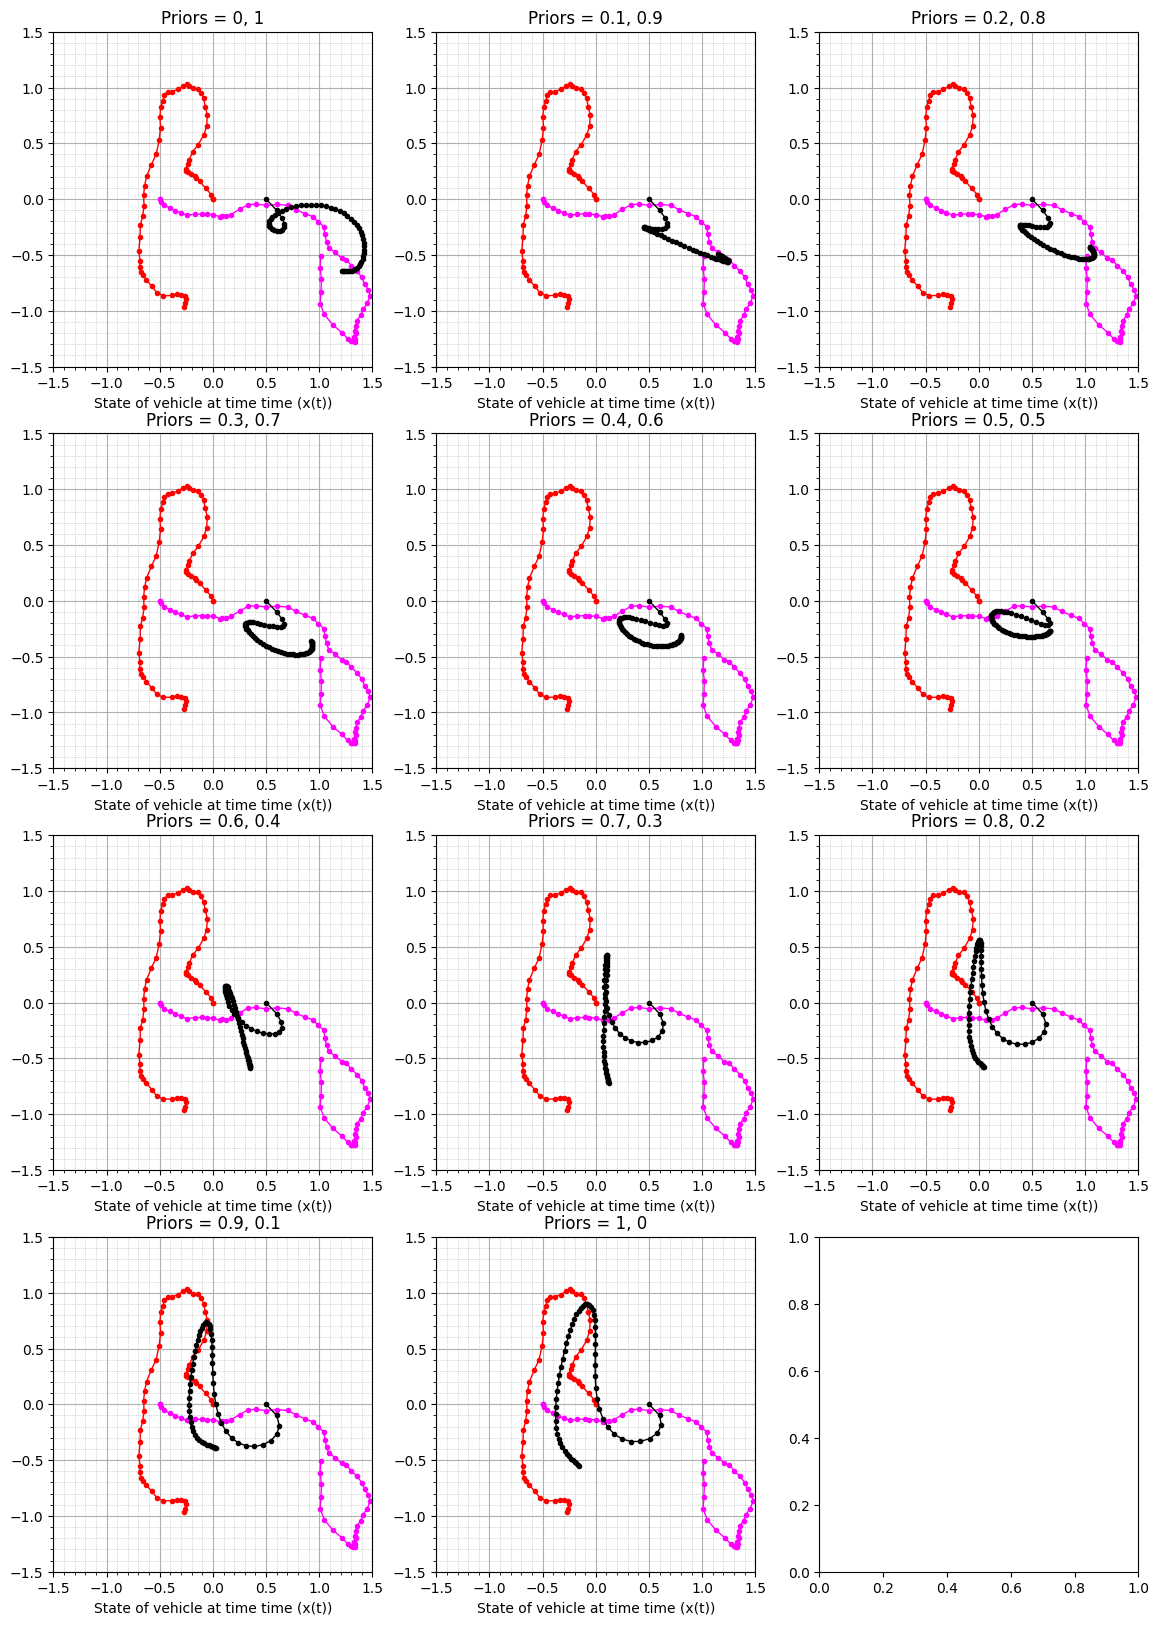

In [14]:
# Create 3x4 subplots (3 rows, 4 cols)
fig, axes = plt.subplots(4, 3, figsize=(14, 20))

# Flatten axes for easy iteration
axes = axes.flatten()

# Plot each trajectory in a separate subplot
for i in range(11):
    ax = axes[i]
    ax.plot(q_t1[0, :], q_t1[1, :], linewidth=1, color='red', linestyle='-')
    ax.plot(q_t1[0, :], q_t1[1, :], 'o', color='red', markersize=3)
    ax.plot(q_t2[0, :], q_t2[1, :], linewidth=1, color='magenta', linestyle='-')
    ax.plot(q_t2[0, :], q_t2[1, :], 'o', color='magenta', markersize=3)
    ax.plot(x_i[i, 0, :], x_i[i, 1, :], linewidth=1, color='black', linestyle='-')
    ax.plot(x_i[i, 0, :], x_i[i, 1, :], 'o', color='black', markersize=3)
    ax.set_title(f'Priors = {prior[i][0]}, {prior[i][1]}')
    ax.set_xlim([-1.5, 1.5])
    ax.set_ylim([-1.5, 1.5])
    ax.grid(True)
    ax.minorticks_on()
    ax.grid(which='major', linestyle='-', linewidth=0.8)      
    ax.grid(which='minor', linestyle=':', linewidth=0.5)   
    ax.set_xlabel('State of vehicle at time time (x(t))')